# Load Final Data

In [ ]:
from utils.process import process

path = "TwiBot22_datasets.csv"
X_train, X_test, y_train, y_test = process(path)

# Model Evaluation

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve

# Create model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Training
rf.fit(X_train, y_train)

# Predicting
y_pred_rf = rf.predict(X_test)

# Evaluate reports
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC curve and AUC
y_prob_rf = rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91    172011
           1       0.48      0.49      0.49     27989

    accuracy                           0.85    200000
   macro avg       0.70      0.70      0.70    200000
weighted avg       0.86      0.85      0.85    200000



## LightGBM

In [ ]:
import lightgbm as lgb
import psutil
import os
import time

# Create model
lgb_model = lgb.LGBMClassifier(is_unbalance=True, verbosity=-1)

# Starting time
start_time = time.time()

# Training
lgb_model.fit(X_train, y_train)

# End time and measure time used
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Measure memory used
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 / 1024  # Đơn vị MB
print(f"Memory usage: {memory_usage} MB")

# Predicting
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate reports
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# ROC curve and AUC
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]
roc_auc_lgb = roc_auc_score(y_test, y_prob_lgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)

# Precision-Recall curve
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_prob_lgb)

Training time: 10.15438461303711 seconds
Memory usage: 1587.0859375 MB
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81    172011
           1       0.31      0.83      0.45     27989

    accuracy                           0.72    200000
   macro avg       0.64      0.76      0.63    200000
weighted avg       0.87      0.72      0.76    200000



## CatBoost

In [ ]:
from catboost import CatBoostClassifier
import psutil
import os
import time

# Create model
catboost_model = CatBoostClassifier(auto_class_weights='Balanced', logging_level='Silent')

# Starting time
start_time = time.time()

# Training
catboost_model.fit(X_train, y_train)

# End time and measure time used
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

# Measure memory used
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / 1024 / 1024  # Đơn vị MB
print(f"Memory usage: {memory_usage} MB")

# Predicting
y_pred_catboost = catboost_model.predict(X_test)

# Evaluate reports
print("Classification Report:")
print(classification_report(y_test, y_pred_catboost))

# ROC curve and AUC
y_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]
roc_auc_catboost = roc_auc_score(y_test, y_prob_catboost)
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_prob_catboost)

# Precision-Recall curve
precision_catboost, recall_catboost, _ = precision_recall_curve(y_test, y_prob_catboost)

Training time: 169.72729086875916 seconds
Memory usage: 1724.46875 MB
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    172011
           1       0.32      0.82      0.46     27989

    accuracy                           0.73    200000
   macro avg       0.64      0.77      0.64    200000
weighted avg       0.87      0.73      0.77    200000



## Plotting

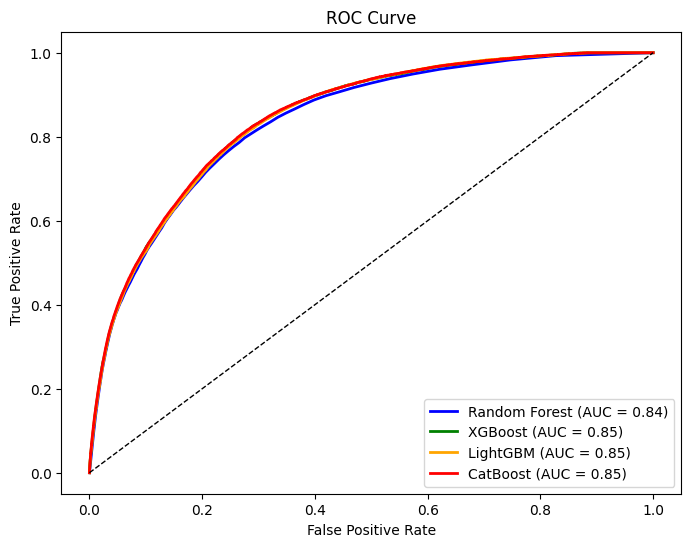

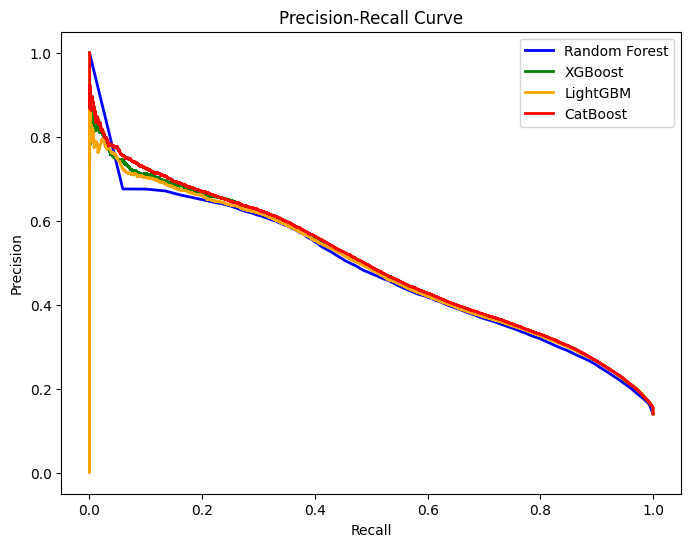

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, color='orange', lw=2, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
plt.plot(fpr_catboost, tpr_catboost, color='red', lw=2, label=f'CatBoost (AUC = {roc_auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label='Random Forest')
plt.plot(recall_xgb, precision_xgb, color='green', lw=2, label='XGBoost')
plt.plot(recall_lgb, precision_lgb, color='orange', lw=2, label='LightGBM')
plt.plot(recall_catboost, precision_catboost, color='red', lw=2, label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Hyperparameters Tunning

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
import random

# Objective function
def objective(params):
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=params['learning_rate'],
        depth=params['depth'],
        l2_leaf_reg=params['l2_leaf_reg'],
        random_seed=42,
        auto_class_weights='Balanced',
        logging_level='Silent'
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score  # Negative since hyperopt minimizes

# Parameters space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

# Optimize parameters with hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials,
            verbose=1,
            rstate=random.seed(42))

# Display best parameters
print("Best params:", best)

100%|██████████| 20/20 [3:52:02<00:00, 696.13s/trial, best loss: -0.9052997000731662]
Best params: {'depth': 8.0, 'l2_leaf_reg': 5.0, 'learning_rate': 0.061248805569778055}


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score
# Define model with best parameters
final_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.061248805569778055,
    depth=8.0,
    l2_leaf_reg=5.0,
    random_seed=42,
    auto_class_weights='Balanced',
    logging_level='Silent'
)

# Train model
final_model.fit(X_train, y_train)

# Evaluate model
y_pred_final = final_model.predict(X_test)

# Print F1 scores
print("F1 scores:", f1_score(y_test, y_pred_final))

# Print F1 macro
print(f"F1 macro: {f1_score(y_test, y_pred_final, average='macro')}")

# Evaluate reports
print("Classification Report:")
print(classification_report(y_test, y_pred_final))

F1 scores: 0.4577672359894008
F1 macro: 0.6375897606174376
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    172011
           1       0.32      0.82      0.46     27989

    accuracy                           0.73    200000
   macro avg       0.64      0.77      0.64    200000
weighted avg       0.87      0.73      0.77    200000

